In [138]:
import math
import torch
import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.contrib.forecast import ForecastingModel, Forecaster, eval_crps
from pyro.infer.reparam import LinearHMMReparam, StableReparam, SymmetricStableReparam
from pyro.ops.tensor_utils import periodic_repeat, periodic_cumsum
from pyro.ops.stats import quantile
import matplotlib.pyplot as plt

%matplotlib inline
assert pyro.__version__.startswith('1.8.4')
pyro.set_rng_seed(20200305)

### GaussianHMM

torch.Size([10000, 4])


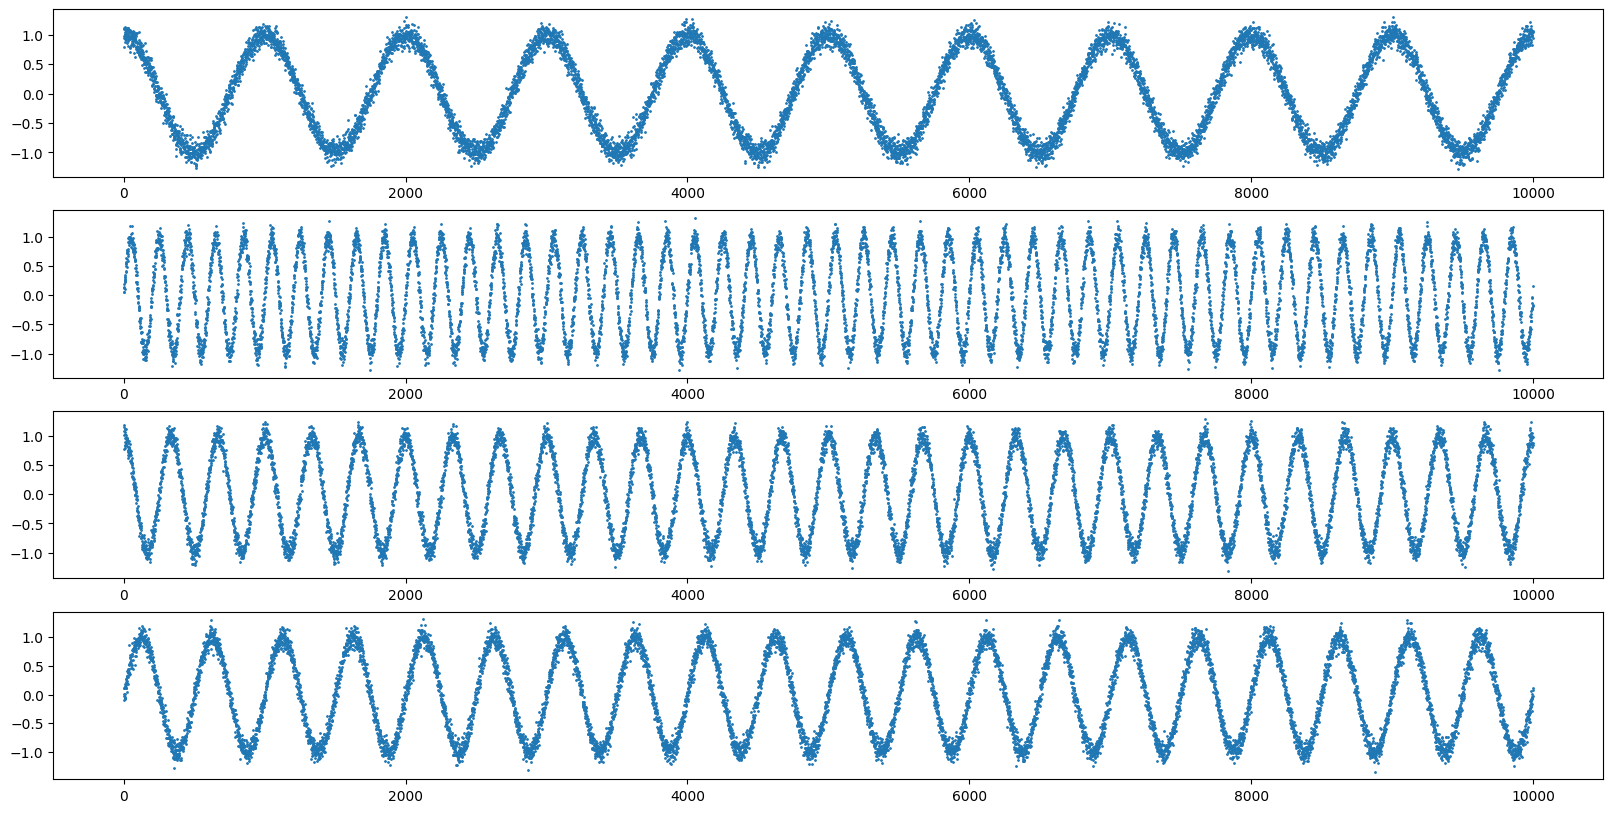

In [139]:
time=torch.linspace(0,2*math.pi*(100),100*100).unsqueeze(-1)
time2D = time.tile((4,))*torch.tensor([0.1,0.5,0.3,0.2])+torch.tensor([math.pi/2,0,math.pi/2,0])
data2D_clean=torch.sin(time2D)
data2D=data2D_clean+torch.randn(data2D_clean.shape)*0.1
print(data2D.shape)

T0_test = 0
T2_test = data2D.size(-2)
T1_test = T2_test-1000 # predict last two cycles

fig,ax=plt.subplots(4,1,figsize=(20,10))
ax[0].scatter(torch.arange(T0_test,T2_test),data2D[:,0],s=1)
ax[1].scatter(torch.arange(T0_test,T2_test),data2D[:,1],s=1)
ax[2].scatter(torch.arange(T0_test,T2_test),data2D[:,2],s=1)
ax[3].scatter(torch.arange(T0_test,T2_test),data2D[:,3],s=1)



In [140]:
class Model1(ForecastingModel):
    def model(self, zero_data, covariates):
        period=1000
        hidden_dim=2
        duration, obs_dim = zero_data.shape[-2:]

        # Sample global parameters.
        # noise_scale = pyro.sample(
        #     "noise_scale", dist.LogNormal(torch.full((dim,), -3.0), 1.0).to_event(1)
        # )
        # assert noise_scale.shape[-1:] == (dim,)

        # Note the initial seasonality should be sampled in a plate with the
        # same dim as the time_plate, dim=-1. That way we can repeat the dim
        # below using periodic_repeat().
        with pyro.plate("season_plate", period, dim=-1):
            season_init = pyro.sample(
                "season_init", dist.Normal(torch.zeros(obs_dim), 1).to_event(1)
            )
        assert season_init.shape[-2:] == (period, obs_dim)

        # Sample independent noise at each time step.
        # with self.time_plate:
        #     season_noise = pyro.sample(
        #         "season_noise", dist.Normal(0, noise_scale).to_event(1)
        #     )
        #     assert season_noise.shape[-2:] == (duration, dim)

        # Construct a prediction. This prediction has an exactly repeated
        # seasonal part plus slow seasonal drift. We use two deterministic,
        # linear functions to transform our diagonal Normal noise to nontrivial
        # samples from a Gaussian process.
        prediction = periodic_repeat(season_init, duration, dim=-2) #+ periodic_cumsum(
        #   season_noise, period, dim=-2
        #)
        assert prediction.shape[-2:] == (duration, obs_dim)

        # We'll hard-code the periodic part of this model, learning only the local model.
        #prediction = periodic_repeat(means, duration, dim=-1).unsqueeze(-1)
        #prediction = periodic_repeat(means, duration, dim=-2)

        # On top of this mean prediction, we'll learn a linear dynamical system.
        # This requires specifying five pieces of data, on which we will put structured priors.
    

        trans_timescale = pyro.sample(
            "trans_timescale", dist.LogNormal(torch.zeros(hidden_dim), 1).to_event(1)
        )
        assert trans_timescale.shape[-1:] == (hidden_dim,)

        trans_loc = pyro.sample("trans_loc", dist.Cauchy(0, 1 / period))
        trans_loc = trans_loc.unsqueeze(-1).expand(trans_loc.shape + (hidden_dim,))
        assert trans_loc.shape[-1:] == (hidden_dim,)
        trans_scale = pyro.sample(
            "trans_scale", dist.LogNormal(torch.zeros(hidden_dim), 0.1).to_event(1)
        )
        trans_corr = pyro.sample("trans_corr", dist.LKJCholesky(hidden_dim, torch.ones(())))
        trans_scale_tril = trans_scale.unsqueeze(-1) * trans_corr
        assert trans_scale_tril.shape[-2:] == (hidden_dim, hidden_dim)

        obs_scale = pyro.sample(
            "obs_scale", dist.LogNormal(torch.zeros(obs_dim), 0.1).to_event(1)
        )
        obs_corr = pyro.sample("obs_corr", dist.LKJCholesky(obs_dim, torch.ones(())))
        obs_scale_tril = obs_scale.unsqueeze(-1) * obs_corr
        assert obs_scale_tril.shape[-2:] == (obs_dim, obs_dim)


        init_dist = dist.Normal(torch.zeros(hidden_dim), 10).to_event(1)
        trans_mat = trans_timescale.neg().exp().diag_embed()
        trans_dist = dist.MultivariateNormal(trans_loc, scale_tril=trans_scale_tril)
        obs_mat = torch.randn(hidden_dim,obs_dim)
        obs_dist = dist.MultivariateNormal(torch.zeros(obs_dim), scale_tril=obs_scale_tril)
        noise_model = dist.GaussianHMM(
            init_dist, trans_mat, trans_dist, obs_mat, obs_dist, duration=duration
        )
        assert noise_model.event_shape == (duration, obs_dim)

        noise_dist = dist.GaussianHMM(
            init_dist, trans_mat, trans_dist, obs_mat, obs_dist, duration=duration)
        self.predict(noise_dist, prediction)

In [141]:
%%time
pyro.set_rng_seed(1)
pyro.clear_param_store()
# covariates = torch.zeros(len(data), 0)  # emptyt
covariates = torch.zeros(len(data2D), 0)  # empty
forecaster = Forecaster(Model1(), data2D[:T1_test], covariates[:T1_test], learning_rate=0.1, num_steps=400)
for name, value in forecaster.guide.median().items():
    if value.numel() == 1:
        print("{} = {:0.4g}".format(name, value.item()))

INFO 	 step    0 loss = 2.76571
INFO 	 step  100 loss = -0.33195
INFO 	 step  200 loss = -0.426152
INFO 	 step  300 loss = -0.449167


trans_loc = 0.001034
CPU times: total: 3min 6s
Wall time: 48.2 s


torch.Size([500, 1000, 4]) torch.Size([1000, 4]) torch.Size([1000, 4])


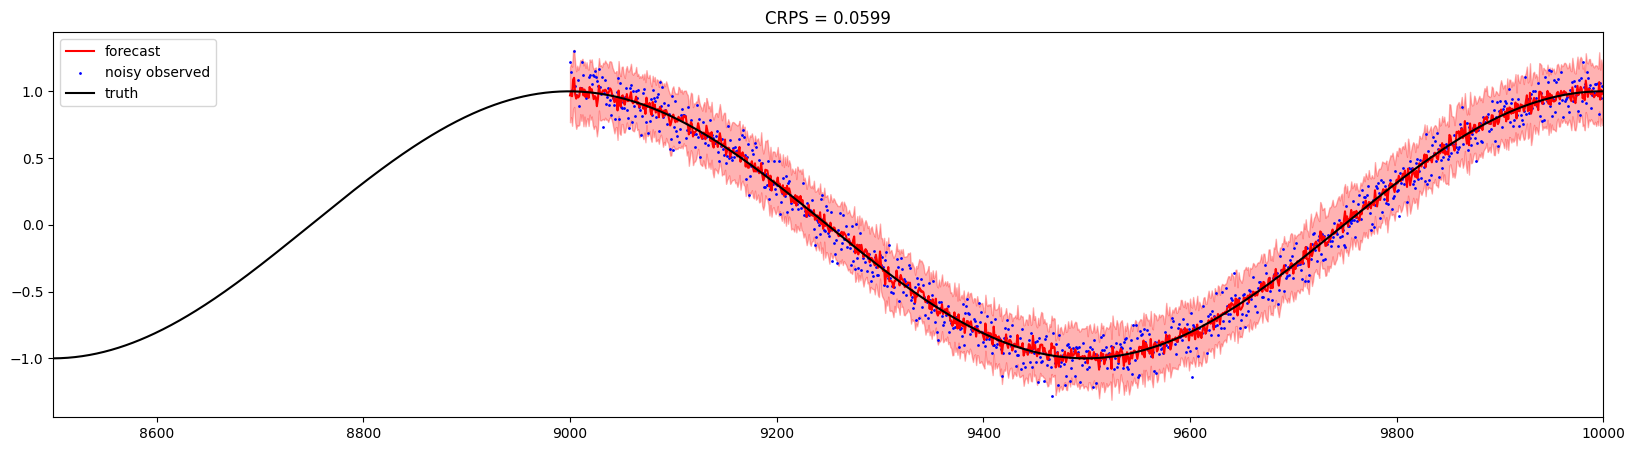

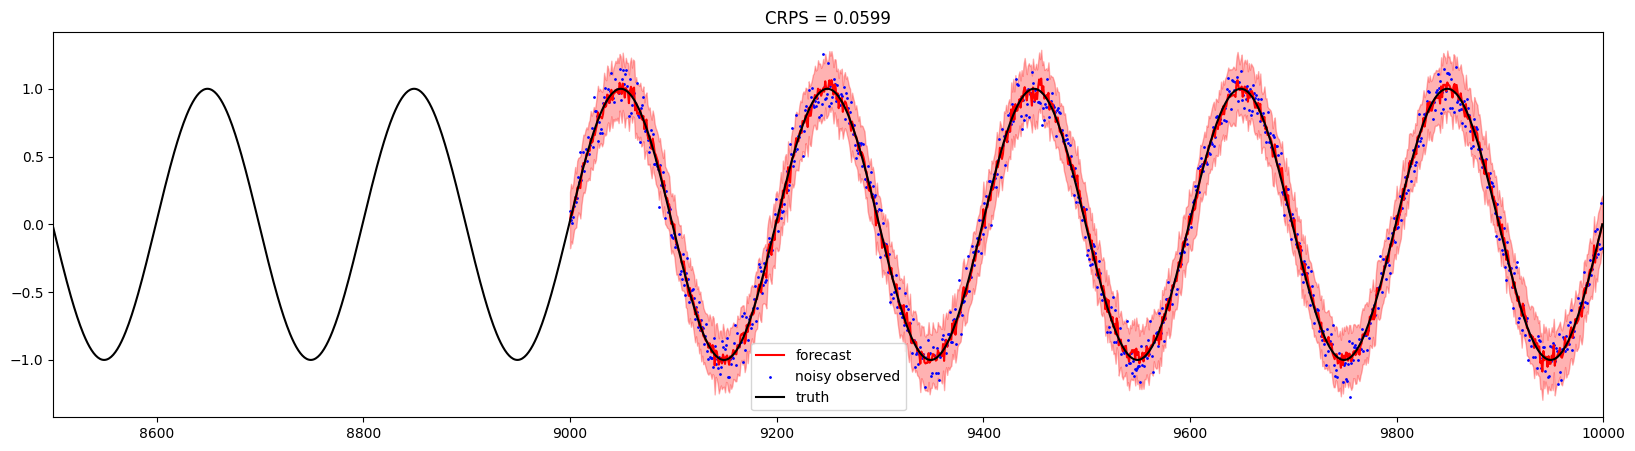

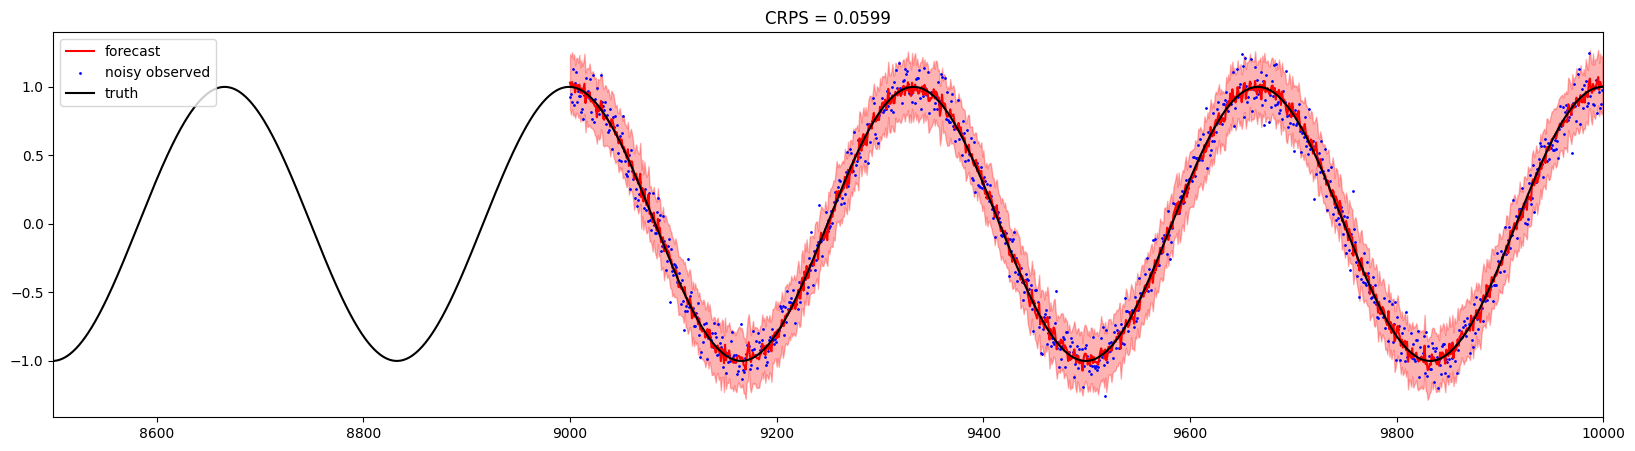

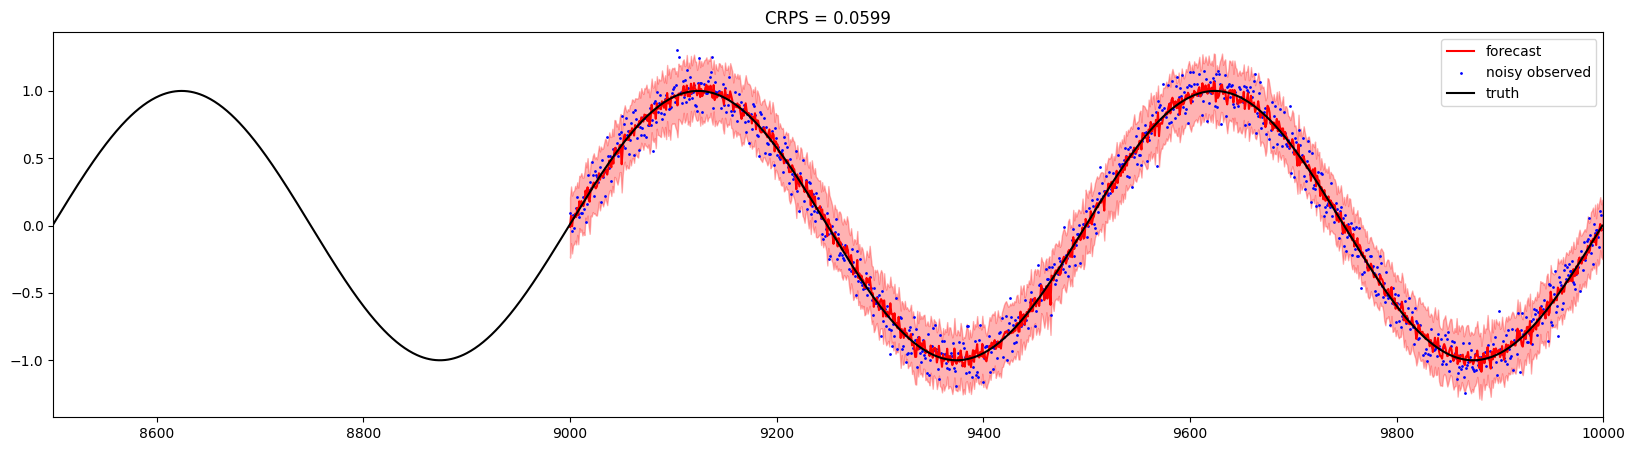

In [142]:
samples = forecaster(data2D[:T1_test], covariates, num_samples=500)
#samples.clamp_(min=0)  # apply domain knowledge: the samples must be positive
p10, p50, p90 = quantile(samples, (0.025, 0.5, 0.975)).squeeze(-1)
meanSamples=samples.mean(dim=0)
crps = eval_crps(samples, data2D[T1_test:])
print(samples.shape, p10.shape,meanSamples.shape)


for printIdx in range(4):
    plt.figure(figsize=(20, 5))
    plt.fill_between(torch.arange(T1_test, T2_test), p10[:,printIdx], p90[:,printIdx], color="red", alpha=0.3)
    #plt.scatter(torch.arange(T1_test, T2_test), p50[:,printIdx], s=1,c='r', label='forecast')
    plt.plot(torch.arange(T1_test, T2_test), meanSamples[:,printIdx], '-r', label='forecast')
    plt.scatter(torch.arange(T1_test, T2_test), data2D[T1_test : T2_test,printIdx], s=1, c='b', label='noisy observed')
    plt.plot(torch.arange(T1_test-(500), T2_test),
            data2D_clean[T1_test-(500) : T2_test,printIdx], 'k-', label='truth')
    plt.title("CRPS = {:0.3g}".format(crps))
    plt.xlim(T1_test-(500), T2_test)
    plt.legend(loc="best");

# plt.figure(figsize=(9, 3))
# plt.fill_between(torch.arange(T1, T2), p10, p90, color="red", alpha=0.3)
# plt.plot(torch.arange(T1, T2), p50, 'r-', label='forecast')
# plt.plot(torch.arange(T1 - 24 * 7, T2),
#          data[T1 - 24 * 7: T2], 'k-', label='truth')
# plt.title("Total hourly ridership (CRPS = {:0.3g})".format(crps))
# plt.ylabel("log(# rides)")
# plt.xlabel("Hour after 2011-01-01")
# plt.xlim(T1 - 24 * 7, T2)
# plt.text(78732, 3.5, "Christmas", rotation=90, color="green")
# plt.legend(loc="best");